# MSBX 5420 Coronavirus Project 
## Spring 2020
### Team Quandary Peak

In [1]:
from __future__ import print_function
import csv, sys, os, nltk, random, logging, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re,string,unicodedata
import pyspark.sql.functions as f
import imageio

from nltk import pos_tag 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize, word_tokenize

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, udf, to_timestamp
from pyspark.sql.types import *

from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from string import punctuation
from matplotlib.animation import FuncAnimation

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Basic Information

In [3]:
#spark_news = spark.read.format('csv').option("escape","\"").option('header',True).load("s3://msbx5420-2020/Team-Quandary-Peak/news.csv/")
#news = spark_news.toPandas()

In [3]:
news = pd.read_csv('./news.csv')
news['publish_date'] = news['publish_date'].str.split(" ", n = 1, expand = True)[0]
news = news[news['publish_date'] >= '2020-01-01']

# Data Cleaning

### Aggregate News by Date

In [4]:
df = news.groupby(['publish_date'], sort = True)['text'].sum().apply(lambda text: ''.join(text))
df = df.reset_index()

In [5]:
spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext\

In [6]:
spark_df = spark.createDataFrame(df)

### Function: Remove Punctuations and Some Words

In [7]:
punctuations = '''!()-[]{};:'"\,<>./`?@#$%^&*_~'''
noword = ['CBC', 'CO', 'Twitter', 'C', 'say', 'says', 'said', 'told', 'out', 'in', 'also', 'The' '\'re', '\'s', 'n\'t', '``', '—', "'", ' '' ', '/']
def clean_text(data):
    #data = dataframe['text'][i]
    stopWords = set(stopwords.words('english'))
    words = word_tokenize(data)

    wordsFiltered = []

    for w in words:
        if w.lower() not in stopWords and w not in punctuations and w not in noword:
                    wordsFiltered.append(w)
    result = ' '.join(wordsFiltered)
    return result
clean_text_udf = udf(clean_text, StringType())

In [10]:
clean_df = spark_df.withColumn("clean_daily_news", clean_text_udf(spark_df['text']))

In [11]:
n = clean_df.count()

In [12]:
clean_df.show(1)

+------------+--------------------+--------------------+
|publish_date|                text|    clean_daily_news|
+------------+--------------------+--------------------+
|  2020-01-08|South Korea has p...|South Korea put 3...|
+------------+--------------------+--------------------+
only showing top 1 row



# Word Count for Entire News from 1/23 to 4/10

In [13]:
clean_df_rdd = clean_df.rdd

In [14]:
counts = clean_df_rdd.flatMap(lambda row: row.clean_daily_news.split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)

In [15]:
word_count_dict = {}
for word, count in counts.collect():
    word_count_dict[word] = count
word_count = pd.DataFrame(word_count_dict.items(),columns = ['word','count'])
sorted_word_count = word_count.sort_values(by = ['count'], ascending = False)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59948)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py", line 316, in _ha

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:37801)

In [ ]:
sorted_word_count[1:11] # sorted_word_count[0] is "''"

### Word Count Visulization -- Entire

In [25]:
py_clean_df = clean_df.toPandas()

In [27]:
d = getcwd()
pic = np.array(Image.open(path.join(d, "covid-19_cdc_image.png")))

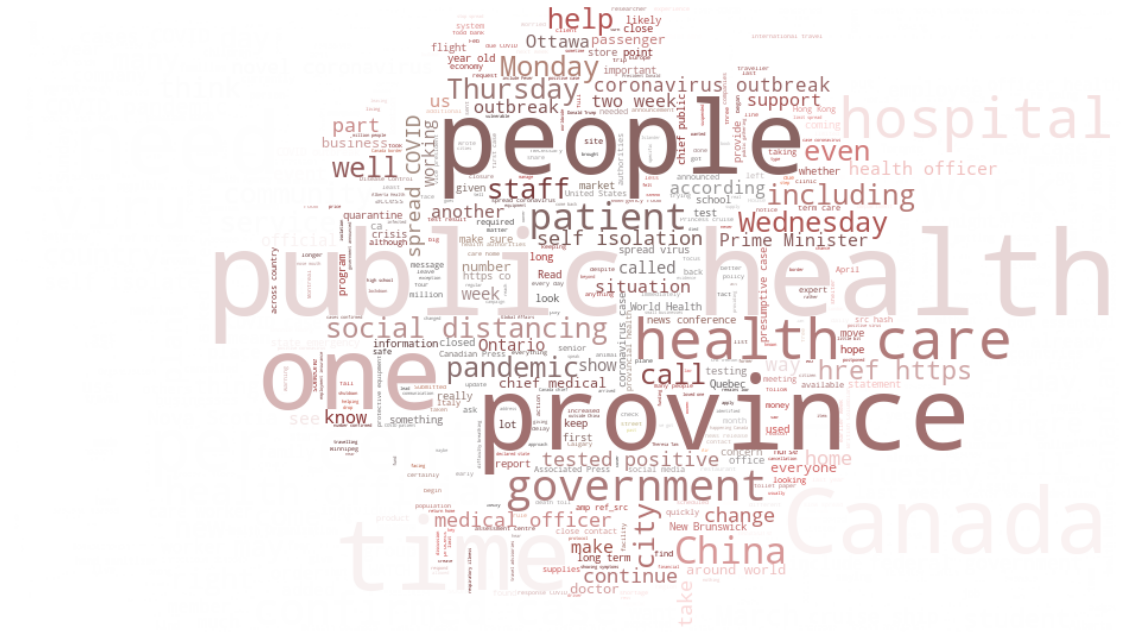

In [28]:
wc = WordCloud(background_color = "white", max_words = 6000, mask = pic, random_state = 45, width = 1280, height = 720)
image = wc.generate(" ".join(py_clean_df.clean_daily_news))
# create coloring from image
image_colors = ImageColorGenerator(pic)
plt.figure(figsize = [20,20])
plt.imshow(wc.recolor(color_func = image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()
image.to_file('word_count_all.jpg')

# Word Frequency for Daily News

### Word Frequency Visualization - Daily

The reason we upload the file without running the following 5 cells is because they will output plots instead of GIFs.

In [ ]:
py_clean_df = clean_df.toPandas()

In [ ]:
from PIL import Image, ImageDraw
images = []
for i in range(n):
    wc = WordCloud(max_words = 1000, random_state = 42, width = 1280, height = 720, colormap = "Blues")
    images = wc.generate(py_clean_df.clean_daily_news[i])
    plt.figure(figsize = [20,20])
    plt.imshow(wc, interpolation = "bilinear")
    plt.title('Timestamp {0}.txt'.format(i))
    plt.axis("off")
    images.to_file("%d.jpg"%(i+1))

### GIF 

In [ ]:
# gif of first 10 days (January)
images = []
names = ["%d.jpg"%(i+1) for i in range(10)]
for name in names:
    frame = Image.open(name)
    images.append(frame)

# Save the frames as an animated GIF
images[0].save('freq_word_plot_1.gif',
               save_all=True,
               append_images = images[1:],
               duration = 600,
               loop = 0)

In [ ]:
# gif of last 10 days (April)
images = []
names = ["%d.jpg"%(i+1) for i in range((n-10), n)]
for name in names:
    frame = Image.open(name)
    images.append(frame)

# Save the frames as an animated GIF
images[0].save('freq_word_plot_2.gif',
               save_all=True,
               append_images = images[1:],
               duration = 600,
               loop = 0)

In [ ]:
# gif of 78 days
images = []
names = ["%d.jpg"%(i+1) for i in range(n)]
for name in names:
    frame = Image.open(name)
    images.append(frame)

# Save the frames as an animated GIF
images[0].save('freq_word_plot_all.gif',
               save_all=True,
               append_images = images[1:],
               duration = 300,
               loop = 0)

### Function: Frequency of Words in Daily News

In [29]:
def get_word_counts(data):

    word_count_dict = {}

    words = word_tokenize(data)

    for word in words:
        if word not in word_count_dict:
            word_count_dict[word] = 0
        word_count_dict[word] += 1

    sorted_word_counts = sorted(word_count_dict.items(), key = lambda kv:kv[1], reverse = True)
   
    freq_word = []
    for word, count in sorted_word_counts[:10]:
        freq_word.append(word)
    freq_word = np.array(freq_word)
        
    result = ' '.join(freq_word)
    return result

get_word_counts_udf = udf(get_word_counts, StringType())

In [30]:
word_df = clean_df.withColumn("frequent_words", get_word_counts_udf(clean_df['clean_daily_news']))
word_df.show(1)

+------------+--------------------+--------------------+--------------------+
|publish_date|                text|    clean_daily_news|      frequent_words|
+------------+--------------------+--------------------+--------------------+
|  2020-01-08|South Korea has p...|South Korea put 3...|Wuhan Chinese pne...|
+------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [31]:
py_word_df = word_df['publish_date', 'frequent_words'].toPandas()

pd.set_option('display.max_colwidth', -1)
py_word_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,publish_date,frequent_words
0,2020-01-08,Wuhan Chinese pneumonia China patients South woman respiratory illness people
1,2020-01-09,cause China pneumonia Chinese SARS new virus outbreak person cases
2,2020-01-11,`` SARS Wuhan outbreak China virus pneumonia Canada 're Health
3,2020-01-12,outbreak China Wuhan market SARS `` one others seafood last
4,2020-01-13,Chinese China Wuhan Health woman quarantined coronavirus Monday monitoring Jan.
...,...,...
73,2020-03-23,`` COVID-19 people health home Monday cases province government 're
74,2020-03-24,`` COVID-19 people health Canada home cases pandemic Tuesday government
75,2020-03-25,`` COVID-19 people health cases 're home workers Canada government
76,2020-03-26,`` COVID-19 people health 're cases home public Canada pandemic


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 53302)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp